# Introduction
This project is to show how to create a recommendation system for e-commerce application using history of user purchase and user interactions. 
the problem is stated in this [document](https://docs.google.com/document/d/1J2_S2fnLn9fDP59W_GncPBFJzj1fiS4YdAlq28l_Tt0/edit?usp=sharing).

# Datasets
In this project, we assumed the data format is strictly using the format as described in the problem document above, but for the sake of better simulate realworld case, the number of records has been adjusted as follows:
* Unique users: 1000
* Unique products: 1000
* Transaction records: 10000
* Purchase history timestamp range: 1-31 Jan 2024

The datasets can be donwloaded [here](https://drive.google.com/drive/folders/1zM_4qbjEUQutxTYtBmu0xwDyCs2S-gcj?usp=sharing)

# Data Preprocessing
* First lets merge those separated datasets so we can get more comprehensive view on the data to see what we can do

In [1]:
import pandas as pd

# Read the CSV file
purchase_history_df = pd.read_csv('newDataset/purchase_history.csv')
product_details_df = pd.read_csv('newDataset/product_details.csv')
customer_interactions_df = pd.read_csv('newDataset/customer_interactions.csv')

# Merge the dataframes  on the common column 'product_id'
ph_pd_merged_df = pd.merge(purchase_history_df, product_details_df, on='product_id')


# print the first 5 rows of the merged dataframe
print(ph_pd_merged_df.head())




   customer_id  product_id purchase_date     category   price  ratings
0          392         785    2024-01-26  Category 13  839.56     2.05
1          256         785    2024-01-19  Category 13  839.56     2.05
2          546         785    2024-01-28  Category 13  839.56     2.05
3           61         785    2024-01-25  Category 13  839.56     2.05
4          977         785    2024-01-22  Category 13  839.56     2.05


* Next we will clean the data 

In [2]:
ph_pd_merged_df = ph_pd_merged_df.dropna()

ph_pd_merged_df

,customer_id,product_id,purchase_date,category,price,ratings
0,392,785,2024-01-26,Category 13,839.56,2.05
1,256,785,2024-01-19,Category 13,839.56,2.05
2,546,785,2024-01-28,Category 13,839.56,2.05
3,61,785,2024-01-25,Category 13,839.56,2.05
4,977,785,2024-01-22,Category 13,839.56,2.05
...,...,...,...,...,...,...
9995,53,350,2024-01-11,Category 14,180.17,3.52
9996,898,350,2024-01-09,Category 14,180.17,3.52
9997,230,350,2024-01-25,Category 14,180.17,3.52
9998,587,350,2024-01-02,Category 14,180.17,3.52


## Play Around with dataset
* Lets take a look of how many times each customer made purchase during January 2024 and plot them

<Axes: >

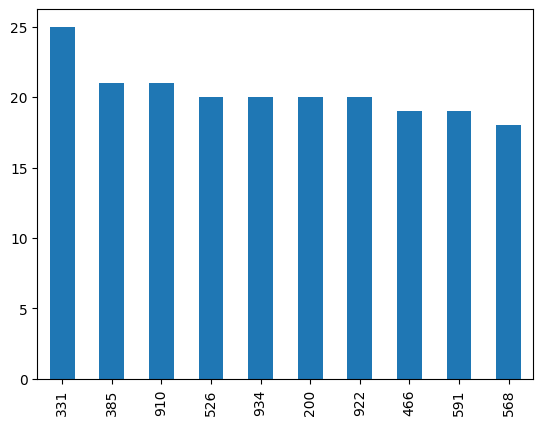

In [11]:
# import the matplotlib library
import matplotlib.pyplot as plt

# calculate the count of how many times each customer made purchases
customer_purchase_count = ph_pd_merged_df['customer_id'].value_counts()

# sort the customer purchase count in descending order
customer_purchase_count = customer_purchase_count.sort_values(ascending=False)

# plot the customer purchase count with a bar chart but limit the number of customers to top 10
customer_purchase_count[:10].plot(kind='bar')
# customer_purchase_count.plot(kind='bar')


We can see users made most purchases. Now lets check users made least purchases

<Axes: >

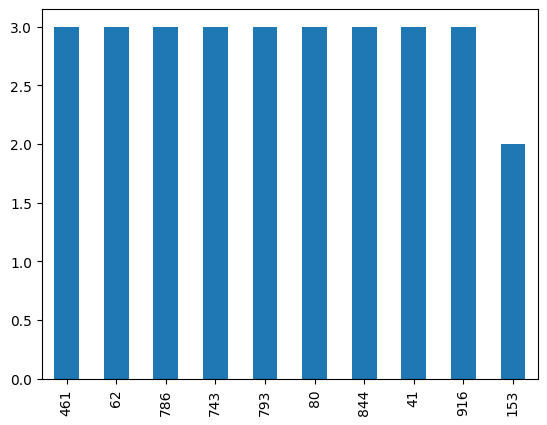

In [14]:
customer_purchase_count[-10:].plot(kind='bar')

Now lets take a look at how many unique items purchased by each customer

<Axes: xlabel='customer_id'>

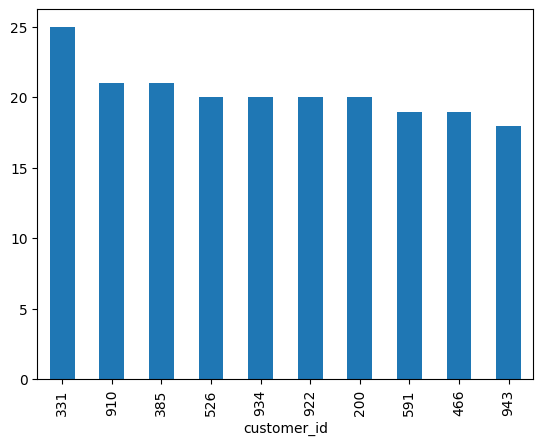

In [16]:
# count how many unique products each customer purchased
customer_unique_purchase_count = ph_pd_merged_df.groupby('customer_id')['product_id'].nunique()

# sort customer_unique_purchase_count in descending order
customer_unique_purchase_count = customer_unique_purchase_count.sort_values(ascending=False)

# plot the customer_unique_purchase_count with a bar chart but limit the number of customers to top 10
customer_unique_purchase_count[:10].plot(kind='bar')

Interesting. it seems top 10 purchasers buy different items every purchase :D (this is why randomly created data is not realistic lol)

So now lets see if it is actually the case for all customers.

In [31]:
# for each customer_unique_purchase_count, compare the value for each customer_id in customer_purchase_count, and check if they are not equal, if not equal, print the customer_id
# customer_unique_purchase_count[customer_unique_purchase_count != customer_purchase_count]
users_bought_items_multiple_times = [(x, customer_unique_purchase_count[x],customer_purchase_count[x] ) for x in customer_unique_purchase_count.index if customer_unique_purchase_count[x] != customer_purchase_count[x] ]
users_bought_items_multiple_times

[(774, 17, 18),
 (427, 16, 17),
 (870, 16, 17),
 (601, 16, 17),
 (781, 15, 16),
 (144, 14, 15),
 (938, 14, 15),
 (354, 14, 15),
 (264, 13, 14),
 (701, 13, 14),
 (265, 13, 14),
 (734, 13, 14),
 (369, 13, 14),
 (556, 13, 14),
 (903, 12, 13),
 (869, 12, 14),
 (313, 12, 13),
 (620, 12, 13),
 (588, 12, 13),
 (203, 12, 13),
 (688, 12, 13),
 (373, 11, 12),
 (948, 11, 12),
 (23, 11, 12),
 (515, 11, 12),
 (541, 11, 12),
 (932, 11, 12),
 (712, 11, 13),
 (818, 11, 12),
 (765, 10, 11),
 (486, 10, 11),
 (277, 10, 11),
 (272, 10, 11),
 (263, 9, 10),
 (85, 9, 10),
 (473, 9, 10),
 (184, 8, 9),
 (131, 8, 9),
 (663, 8, 9),
 (931, 8, 9),
 (260, 8, 9),
 (858, 7, 8),
 (964, 6, 7),
 (148, 5, 6)]

Yes we got some users bought an item more than once. lets count them.

In [32]:
# count element of users_bought_items_multiple_times
len(users_bought_items_multiple_times)

44

Only 44 of 1000, less than 5%. I think we can ignore them.

Lets see from the product perspective. How about most purchased products

<Axes: >

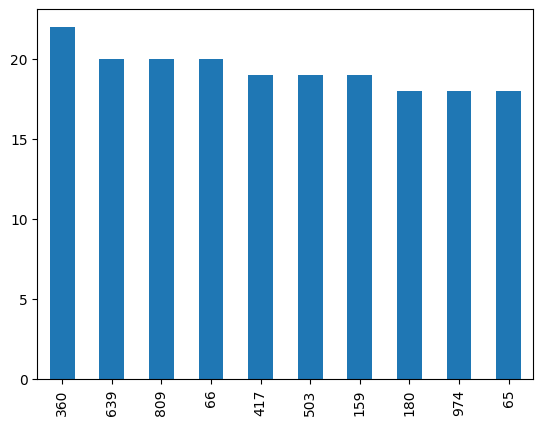

In [40]:
# print 10 most purchased products by customers
product_purchase_count = ph_pd_merged_df['product_id'].value_counts()

# sort product_purchase_count in descending order
product_purchase_count = product_purchase_count.sort_values(ascending=False)

# plot the product_purchase_count with a bar chart limit to top 10 products
product_purchase_count[:10].plot(kind='bar')

Okay, how about we count most purchased product category

<Axes: >

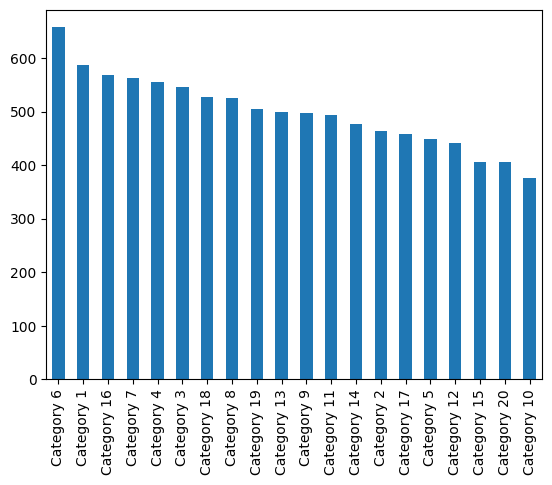

In [41]:
# print 10 most purchased products by category
product_category_purchase_count = ph_pd_merged_df['category'].value_counts()

# sort product_purchase_count in descending order
product_category_purchase_count = product_category_purchase_count.sort_values(ascending=False)

# plot the product_purchase_count with a bar chart 
product_category_purchase_count.plot(kind='bar')

Now lets take a look the categories of top 10 purchased products

In [43]:
# filter product_details_df to only include product_id in product_purchase_count top 10
product_details_df[product_details_df['product_id'].isin(product_purchase_count[:10].index)]


,product_id,category,price,ratings
64,65,Category 7,984.04,4.18
65,66,Category 17,529.78,3.51
158,159,Category 8,254.77,1.65
179,180,Category 13,351.31,1.90
359,360,Category 13,234.48,4.25
416,417,Category 16,592.11,1.08
502,503,Category 4,134.95,4.25
638,639,Category 11,570.58,3.47
808,809,Category 10,32.43,4.84
973,974,Category 15,426.24,1.53


Looks like most purchased products not necessarily in most purchased product category. So I think for the recommendation system, we are going to see the user-category interactions instead of user-product interactions. Although we can also compare both approach too. Obviously the only way to go is using collaborative filtering for recommendation with user-based or item-based. But lets go with user-based first.

First lets create user-category interaction matrix

In [85]:
# create user-product interaction matrix from ph_pd_merged_df using count of category
user_product_interaction_with_category = ph_pd_merged_df.pivot_table(index='customer_id', columns='category', values='product_id', aggfunc='count')
# fill NaN values with 0
user_product_interaction_with_category = user_product_interaction_with_category.fillna(0)

user_product_interaction_with_category

category,Category 1,Category 10,Category 11,Category 12,Category 13,Category 14,Category 15,Category 16,Category 17,Category 18,Category 19,Category 2,Category 20,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9
customer_id,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,1.0,0.0,1.0,1.0
4,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0
5,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
997,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
998,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [86]:
# compute the cosine similarity between each user
from sklearn.metrics.pairwise import cosine_similarity
user_similarity_with_category = cosine_similarity(user_product_interaction_with_category)

In [87]:
user_similarity_df = pd.DataFrame(user_similarity_with_category, index=user_product_interaction_with_category.index, columns=user_product_interaction_with_category.index)
user_similarity_df

customer_id,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.094491,0.769800,0.639602,0.327327,0.360844,0.447214,0.294628,0.111803,0.294174,...,0.412479,0.603023,0.467707,0.288675,0.387298,0.237171,0.670820,0.401478,0.237171,0.250000
2,0.094491,1.000000,0.218218,0.161165,0.000000,0.327327,0.253546,0.356348,0.169031,0.296500,...,0.267261,0.341882,0.000000,0.327327,0.390360,0.239046,0.338062,0.260133,0.597614,0.188982
3,0.769800,0.218218,1.000000,0.492366,0.587945,0.500000,0.645497,0.589692,0.258199,0.452911,...,0.635053,0.464207,0.565779,0.444444,0.347833,0.243432,0.516398,0.309058,0.486864,0.384900
4,0.639602,0.161165,0.492366,1.000000,0.139573,0.123091,0.476731,0.251259,0.190693,0.334497,...,0.201008,0.578542,0.512823,0.184637,0.385337,0.539360,0.476731,0.293470,0.202260,0.213201
5,0.327327,0.000000,0.587945,0.139573,1.000000,0.440959,0.585540,0.617213,0.292770,0.599145,...,0.617213,0.197386,0.233285,0.440959,0.281718,0.345033,0.390360,0.400501,0.414039,0.218218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.237171,0.239046,0.243432,0.539360,0.345033,0.182574,0.424264,0.521749,0.282843,0.558156,...,0.447214,0.286039,0.253546,0.456435,0.571548,1.000000,0.565685,0.435286,0.400000,0.000000
997,0.670820,0.338062,0.516398,0.476731,0.390360,0.129099,0.500000,0.527046,0.000000,0.438529,...,0.316228,0.539360,0.358569,0.387298,0.346410,0.565685,1.000000,0.615587,0.424264,0.000000
998,0.401478,0.260133,0.309058,0.293470,0.400501,0.198680,0.564288,0.432590,0.307794,0.404929,...,0.378517,0.553372,0.245256,0.463586,0.414644,0.435286,0.615587,1.000000,0.290191,0.000000


That takes some time. Now lets see if we can get 10 recommended products for given customer_id

In [88]:
# create a function to find the most similar users
def most_similar_users(user_id, user_similarity, topn=10):
    user = user_similarity[user_id]
    return user.argsort()[::-1][1:topn+1]

Here is how we are going to construct the recommendation algorithm:
* we first find the category where that particular user has bought product from multiple times. The threshold is 2 
* if such categories exist, for each category find one product in those categories that has not previously purchased by the user. 
* if we reach the target number of product recommendation, stop here.
* Next we use regular collaborative filtering method by finding similar user and find product categories purchased by those similar users
* for each categories we go from the top most purchased and recommend products that has not been purchased by the user until ge achieved number or products to be recommended

Looks like we're gonna need user-product interaction matrix with product_id anyway


In [95]:
# create user-product interaction matrix from ph_pd_merged_df using count of product_id

user_product_interaction_with_product_id = ph_pd_merged_df.pivot_table(index='customer_id', columns='product_id', values='category', aggfunc='count')
user_product_interaction_with_product_id = user_product_interaction_with_product_id.fillna(0)
user_product_interaction_with_product_id

product_id,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
# create function to recommend products to a user
def recommend_products(user_id, user_product_interaction_category, user_product_interaction, user_similarity, topn=10, purchased_category_treshold=2):
    reommended_products = []

    
    # find the products that the user_id has already purchased
    products_purchased_category = user_product_interaction_category.loc[user_id]
    products_purchased_product_id = user_product_interaction.loc[user_id]

    products_purchased_category = products_purchased_category[products_purchased_category > purchased_category_treshold].sort_values(ascending=False)    
    product_ids_from_reccurance_purchased = product_details_df.apply(lambda x: {"product_id": x['product_id'], "category": x['category']} if x['category'] in products_purchased_category.index else None, axis=1)
    product_ids_from_reccurance_purchased = product_ids_from_reccurance_purchased.dropna()
    # obtain one item for each category from product_ids_from_reccurance_purchased where product_id is not in products_purchased_product_id
    selected_categories = {}
    # print(products_purchased_product_id[products_purchased_product_id > 0])
    # print(product_ids_from_reccurance_purchased)
    for row in product_ids_from_reccurance_purchased:
        if row['product_id'] not in products_purchased_product_id[products_purchased_product_id > 0] and selected_categories.get(row['category']) == None:
            reommended_products.append(row['product_id'])
            selected_categories[row['category']] = True

    # find the most similar users to the user_id
    most_similar = most_similar_users(user_id, user_similarity, topn)
    most_similar = most_similar[most_similar > 0]
    similar_users = user_product_interaction_category.loc[most_similar]
    # sum the purchase count of each product by similar users
    recommendations = similar_users.sum().sort_values(ascending=False)
    recommendations = recommendations.drop(products_purchased_category[products_purchased_category > 0].index, errors='ignore')

    if(len(reommended_products) < topn):
        for category in recommendations.index:
            product_id = product_details_df[product_details_df['category'] == category].iloc[0]['product_id']
            if product_id not in products_purchased_product_id[products_purchased_product_id > 0]:
                reommended_products.append(product_id)
                if(len(reommended_products) >= topn):
                    break
    #         if product_id not in products_purchased_product_id[products_purchased_product_id > 0] and len(reommended_products) < topn:
    #             reommended_products.append(product_id)

    # print(recommendations)
    return reommended_products

In [128]:
recommend_products(user_id=123, user_product_interaction_category=user_product_interaction_with_category, user_product_interaction=user_product_interaction_with_product_id , user_similarity=user_similarity_with_category, topn=10)
# most_similar_users(user_id=568, user_similarity=user_similarity)

[38, 1, 14, 11, 9, 17, 36, 65, 13, 16]

Now we have some kind of recommendation engine for a given user ID. Lets see if we can evaluate the accuracy 

In [130]:
# Create a function train the datasets given dataframes and return user_product_interaction_category, user_product_interaction and user_similarity
def train_datasets(ph_pd_merged_df):

    # create user-product interaction matrix from ph_pd_merged_df using count of category
    user_product_interaction_with_category = ph_pd_merged_df.pivot_table(index='customer_id', columns='category', values='product_id', aggfunc='count')
    # fill NaN values with 0
    user_product_interaction_with_category = user_product_interaction_with_category.fillna(0)

    # compute the cosine similarity between each user
    from sklearn.metrics.pairwise import cosine_similarity
    user_similarity_with_category = cosine_similarity(user_product_interaction_with_category)

    user_similarity_df = pd.DataFrame(user_similarity_with_category, index=user_product_interaction_with_category.index, columns=user_product_interaction_with_category.index)

    # create user-product interaction matrix from ph_pd_merged_df using count of product_id
    user_product_interaction_with_product_id = ph_pd_merged_df.pivot_table(index='customer_id', columns='product_id', values='category', aggfunc='count')
    user_product_interaction_with_product_id = user_product_interaction_with_product_id.fillna(0)

    return user_product_interaction_with_category, user_product_interaction_with_product_id, user_similarity_df

In [158]:
# split ph_pd_merged_df into train and test datasets
from sklearn.model_selection import train_test_split
train, test = train_test_split(ph_pd_merged_df, test_size=0.2)

# retrain the datasets
user_product_interaction_with_category, user_product_interaction_with_product_id, user_similarity_df = train_datasets(train)


In [157]:
# create a function to obtain set of categories from set of product ids

def get_categories_from_product_ids(product_ids, product_details_df):
    categories = set()
    for product_id in product_ids:
        category = product_details_df[product_details_df['product_id'] == product_id].iloc[0]['category']
        categories.add(category)
    return categories

In [162]:
# create a function that will evaluate the model by calculating the precision and recall
def evaluate_model(test, user_product_interaction_category, user_product_interaction, user_similarity, topn=10, purchased_category_treshold=2):
    precision = 0
    recall = 0
    count = 0
    for user_id in test['customer_id'].unique():
        # print(user_id)
        recommended_products = recommend_products(user_id, user_product_interaction_category, user_product_interaction, user_similarity, topn, purchased_category_treshold)
        actual_products = test[test['customer_id'] == user_id]['product_id'].values
        if len(recommended_products) > 0 and len(actual_products) > 0:
            precision += len(set(recommended_products).intersection(set(actual_products))) / len(recommended_products)
            recall += len(set(recommended_products).intersection(set(actual_products))) / len(actual_products)
            count += 1
    return precision/count, recall/count

In [163]:
# evaluate the model
precision, recall = evaluate_model(test, user_product_interaction_with_category, user_product_interaction_with_product_id, user_similarity_df, topn=10)

In [164]:
print(precision, recall)

0.0021028037383177575 0.009014797507788162


Hmm.. not so good in `precission` and `recall`. 

I think this is because we focus on `category` based recommendation instead of product. So lets fix our `evaluate_model` function to consider the category

In [176]:
def evaluate_model_improved(test, user_product_interaction_category, user_product_interaction, user_similarity, topn=10, purchased_category_treshold=2):
    precision = 0
    recall = 0
    count = 0
    for user_id in test['customer_id'].unique():
        # print(user_id)
        recommended_products = recommend_products(user_id, user_product_interaction_category, user_product_interaction, user_similarity, topn, purchased_category_treshold)
        actual_products = test[test['customer_id'] == user_id]['product_id'].values
        if len(recommended_products) > 0 and len(actual_products) > 0:
            # calculate precision by counting the number of recommended products that the category match with actual products
            match_category_products_count = 0
            for product_id in recommended_products:
                category = product_details_df[product_details_df['product_id'] == product_id].iloc[0]['category']
                if category in get_categories_from_product_ids(actual_products, product_details_df):
                    match_category_products_count += 1

            precision += match_category_products_count / len(recommended_products)
            recall += match_category_products_count / len(actual_products)
            count += 1
    return precision/count, recall/count

In [172]:
precision, recall = evaluate_model_improved(test, user_product_interaction_with_category, user_product_interaction_with_product_id, user_similarity_df, topn=10)

In [173]:
print(precision, recall)

0.11588785046728918 0.5093513573653764


Okay so now we have improved it. the number is much better if we calculate the precision and recall when consider the product we recommended is within the product category that the user actualy purchase in test data set.

Lets see if we increase the number of recommendation to 20

In [174]:
precision, recall = evaluate_model_improved(test, user_product_interaction_with_category, user_product_interaction_with_product_id, user_similarity_df, topn=20)

In [175]:
print(precision, recall)

0.11145713778214943 0.9618352247441032


We can see the number of recall increased with slightly reduce on precision. So I think we have a pretty solid model. Now we need to deploy this to the web application

# ~Web Application~ Data Spreadsheet ?
For this particular case we will not create a web application with common frameworks, but since the target users is people from marketing departement, we will create a simple extension in google spreadsheet combined with some google app script to handle some logic. 

In [182]:
user_product_interaction_with_category, user_product_interaction_with_product_id, user_similarity_df = train_datasets(ph_pd_merged_df)
# pickle user_product_interaction_with_category, user_product_interaction_with_product_id, user_similarity_df
import pickle
with open('user_product_interaction_with_category.pkl', 'wb') as f:
    pickle.dump(user_product_interaction_with_category, f)
with open('user_product_interaction_with_product_id.pkl', 'wb') as f:
    pickle.dump(user_product_interaction_with_product_id, f)
with open('user_similarity_df.pkl', 'wb') as f:
    pickle.dump(user_similarity_df, f)
with open('product_details_df.pkl', 'wb') as f:
    pickle.dump(product_details_df, f)

Then we create the web application that utilizes the pickled model to give recommendations.
The code is in the `ecommorece_recommendation.py` file.

Now we also going to generate some customer and product names and put it in the google app script.

In [187]:
import faker

# Initialize a Faker generator
fake = faker.Faker()

# Generate 1000 random customer names
customer_names = [fake.name() for _ in range(1000)]

# Generate 1000 random product names
product_names = [fake.word() for _ in range(1000)]

# Display the first 10 names as a sample
product_names[:10]


['exactly',
 'officer',
 'blue',
 'middle',
 'value',
 'one',
 'produce',
 'store',
 'home',
 'point']

In [189]:
import random

product_types = ["Phone", "Laptop", "Tablet", "Camera", "Headphones", "Speaker", "Monitor", "Keyboard", "Mouse", "Charger"]
materials = ["Steel", "Wooden", "Plastic", "Metal", "Rubber", "Silicone", "Leather", "Glass", "Ceramic", "Cotton"]
adjectives = ["Smart", "Portable", "Wireless", "Ergonomic", "Compact", "Rugged", "Sleek", "Durable", "Lightweight", "Powerful"]


# Re-initialize the Faker generator
fake = faker.Faker()

# Generate product names by manually combining elements from the lists
product_names = []
for _ in range(1000):
    adjective = random.choice(adjectives)
    material = random.choice(materials)
    product_type = random.choice(product_types)
    # To add more uniqueness, we can also prepend or append a random number
    random_number = random.randint(1, 999)
    product_name = f"{adjective} {material} {product_type} {random_number}"
    product_names.append(product_name)

# Display the first 10 product names as a sample
product_names[:10]

['Powerful Wooden Mouse 709',
 'Wireless Ceramic Mouse 355',
 'Portable Glass Mouse 830',
 'Portable Steel Headphones 147',
 'Durable Glass Phone 437',
 'Smart Plastic Speaker 371',
 'Wireless Wooden Laptop 97',
 'Ergonomic Silicone Headphones 32',
 'Powerful Leather Mouse 113',
 'Ergonomic Steel Headphones 675']

# Deployment

We host the web app on gcp instance. can be accessesed publicly so it can be called from the script within the google spreadsheet.
url: http://34.172.129.130/recommend?user_id=1&topn=10

Overall, we have the final product can be accessed here:

https://docs.google.com/spreadsheets/d/1ti0fxX2t5ruE8tWHBVkFwr759F_rr8Mleo5sQpL9-yk/edit?usp=sharing

Please see the video on how to test the application. Note on first time run, the google script will ask for permission once. 
